## import libraries

In [1]:
import cv2, os, json, math, pickle, fnmatch
import spiceypy as spice
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation as R
from utils import contrast_resize, train, test, load, save
from datetime import datetime

### for figure readability

In [2]:
plt.rcParams.update({'font.family': 'Serif'})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.max_open_warning': 0})

### useful globals

In [8]:
TRAIN_DIR = os.path.expanduser("~/eigenjuno/DATA/TRAIN/")
TEST_DIR = os.path.expanduser("~/eigenjuno/DATA/TEST/")
KERNEL_DIR = os.path.expanduser("~/eigenjuno/STITCHING/KERNELS/CURRENT/")
VEC_SIZE = 256 * 256 * 3
VEC_DIM = (256, 256, 3)
TRAIN_SIZE = 400
# TEST_NAME = 6745
TEST_IMGS = [6881, 6882, 6884, 6923]

## read in training/testing data

In [4]:
tags = np.empty(TRAIN_SIZE)
data = np.empty((TRAIN_SIZE, VEC_SIZE))

for r, d, f in os.walk(TRAIN_DIR + 'ONE/'):
    for file in f:
        num = int(file.split('.')[0])
        tags[num - 1] = 1
        img = mpimg.imread(os.path.join(TRAIN_DIR, 'ONE/' + str(num) + '.png'))
        data[num - 1, :] = img[:, :, :3].reshape(VEC_SIZE)
        
for r, d, f in os.walk(TRAIN_DIR + 'ZERO/'):
    for file in f:
        num = int(file.split('.')[0])
        tags[num - 1] = 0
        img = mpimg.imread(os.path.join(TRAIN_DIR, 'ZERO/' + str(num) + '.png'))
        data[num - 1, :] = img[:, :, :3].reshape(VEC_SIZE)

tags = tags.astype('uint8')

## perform training w/ pca and eigenimaging

In [ ]:
## call custom training function
svm, pca = train(data, tags)

# dump model data for safe-keeping
pickle.dump(svm, open('MODELS/svm_model_' + datetime.now().strftime("%d:%m:%Y_%H:%M:%S") + '.sav', 'wb'))

## divide-(and shift)-and-conquer pipeline

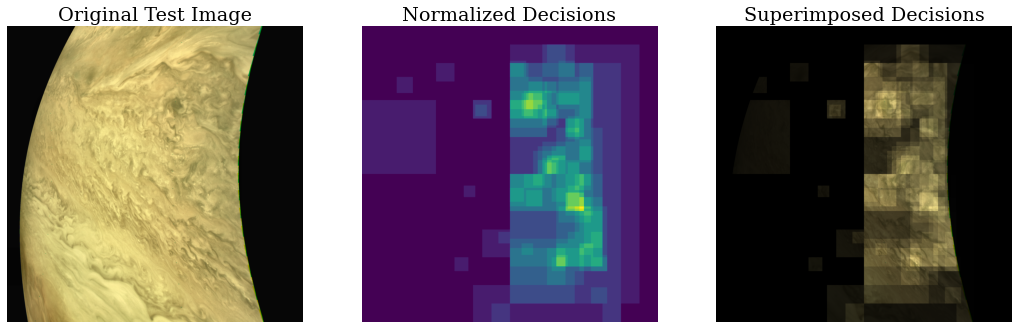

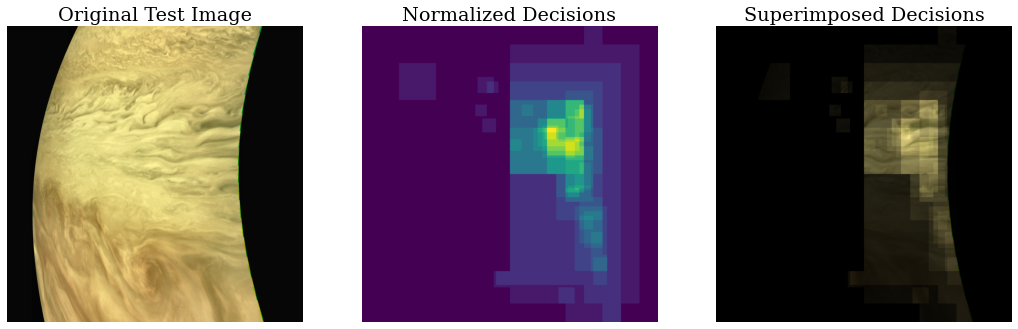

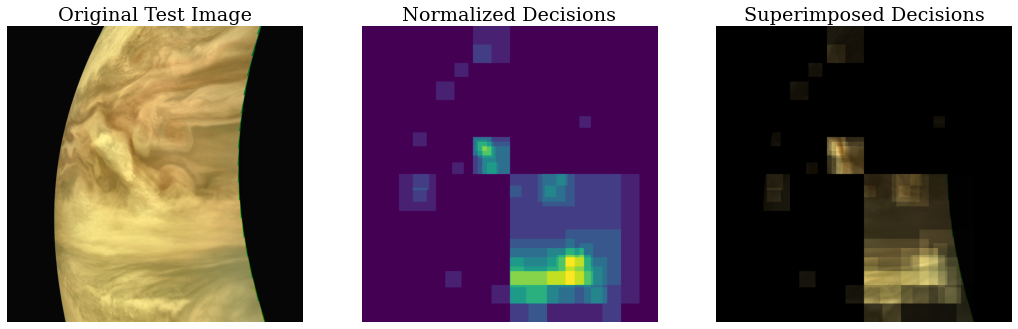

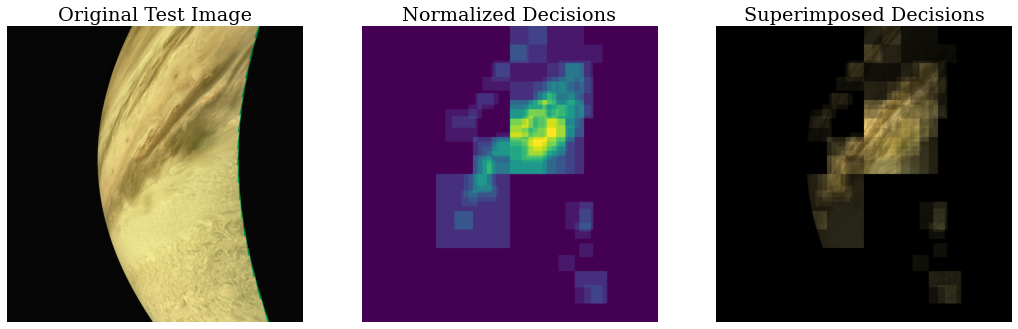

In [9]:
for TEST_NAME in TEST_IMGS:
    detections = test(os.path.join(TEST_DIR, str(TEST_NAME) + '-Stitched.png'))

--------------------------------------------------------------------------------------------------------------------------

### contrast and resize new training images

In [ ]:
for r, d, f in os.walk(TRAIN_DIR + 'PROCESS/'):
    for file in f:
        num = int(file.split('.')[0])
        img = contrast_resize(os.path.join(TRAIN_DIR, 'PROCESS/' + str(num) + '.png'), (256, 256))
        plt.imsave(os.path.join(TRAIN_DIR, 'ONE/' + str(num) + '.png'), img)

### display contrasted dataset

In [ ]:
fig, axes = plt.subplots(7, 7, figsize = (15, 20));
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i, :].reshape(VEC_DIM))
    ax.title.set_text('VALUE ' + str(int(tags[i])))
    ax.title.set_fontsize(14)
    ax.axis('off')
fig.savefig('FIGURES/display_dataset.png')

### visualize results w/ images

In [ ]:
fig, axes = plt.subplots(6, 6, figsize = (15, 20));
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i - 1, :].reshape(VEC_DIM))
    ax.title.set_text('VALUE ' + str(int(y_test[i - 1])) + "\n PREDICTED " + str(int(y_pred[i - 1])))
    ax.title.set_fontsize(14)
    ax.axis('off')
plt.savefig('FIGURES/sample_outputs.png')

### pca with uncontrasted data - fewer components

In [ ]:
pca_MIN = PCA(n_components = pca.components_.shape[0]).fit(data)
plt.figure(figsize = (10, 7));
plt.plot(pca_MIN.explained_variance_ratio_.cumsum(), color = 'seagreen');
plt.xlabel('Number of Principal Components');
plt.ylabel('Explained Variance Ratio');
plt.title('Explained Variance Ratio of\nPrincipal Components in a Contrasted Dataset');
plt.savefig('FIGURES/pca_variance.png')

### visualize support vectors

In [ ]:
sv_indices = svm.best_estimator_.support_
fig, axes = plt.subplots(5, 4, figsize = (18, 22))
for i, ax in enumerate(axes.flat):
    if i < sv_indices.size:
        ax.imshow(pca.inverse_transform(svm.best_estimator_.support_vectors_[i, :]).reshape((VEC_DIM)).astype(float).clip(0, 1))
        ax.axis('off')
    else:
        fig.delaxes(ax)
fig.savefig('FIGURES/support_vectors.png')

### visualize eigenfaces

In [ ]:
fig, axes = plt.subplots(5, 4, figsize = (18, 25))
for i, ax in enumerate(axes.flat):
    if i < pca.components_.shape[0]:
        ax.title.set_text(str(pca.singular_values_[i]))
        ax.imshow((pca.components_[i, :].reshape((VEC_DIM)) * 255).astype(float).clip(0, 1))
        ax.axis('off')
    else:
        fig.delaxes(ax)
fig.savefig('FIGURES/eigenfaces.png')

### variance of training space parameter vs num support vectors

In [ ]:
G_RANGE = np.logspace(-9, 1, 20)

NUM_SVS = []

data_PCA = pca.transform(data)

for G in G_RANGE:
    svm = SVC(C = 1, kernel = 'rbf', gamma = G, class_weight = 'balanced')
    svm.fit(data_PCA, tags)
    NUM_SVS.append(svm.support_vectors_.shape[0])
    
plt.figure(figsize = (10, 7));
plt.plot(C_RANGE, NUM_SVS, color = 'lightcoral');
plt.xscale('log');
plt.xlabel('G');
plt.ylabel('Support Vectors');
plt.title('Gamma Value (Variance of Training Space)\nvs. Number of Support Vectors')
plt.savefig('FIGURES/gamma_sv_tradeoff.png')

### gamma vs number of support vectors

In [ ]:
C_RANGE = np.logspace(-2, 4, 20)

NUM_SVS = []

data_PCA = pca.transform(data)

for C in C_RANGE:
    svm = SVC(C = C, kernel = 'rbf', gamma = 'scale', class_weight = 'balanced')
    svm.fit(data_PCA, tags)
    NUM_SVS.append(svm.support_vectors_.shape[0])
    
plt.figure(figsize = (10, 7));
plt.plot(C_RANGE, NUM_SVS, color = 'darkorchid');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Support Vectors');
plt.title('Cost Value (L2 Regularization Parameter)\nvs. Number of Support Vectors')
plt.savefig('FIGURES/cost_sv_tradeoff.png')

### simple pca example

In [ ]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax2 = fig.add_subplot(1, 2, 2)

n = 100

xyz = np.empty((n, 3))

## generate random 3D data
xyz[:, 0] = np.linspace(0, 1, 100)
xyz[:, 1] = np.sin(9 * xyz[:, 0]) + np.sqrt(1 / 3.0) * np.random.randn(n)
xyz[:, 2] = np.random.rand(n)

## define binary classes - green triangle, pink circle
for i in range(xyz.shape[0]):
    if xyz[i, 1] < 0.5:
        ax1.scatter(xyz[i, 0], xyz[i, 1], xyz[i, 2], marker = '^', color = 'green')
    else:
        ax1.scatter(xyz[i, 0], xyz[i, 1], xyz[i, 2], marker = 'o', color = 'hotpink')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Data before PCA (3D)')

for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax1.get_zticklabels()):
    label.set_fontsize(12)

## reduce dimension from 3D to 2D
pca_xyz = PCA(n_components = 2).fit(xyz)
xyz_d = pca_xyz.transform(xyz)

for i in range(xyz.shape[0]):
    if xyz[i, 1] < 0.5:
        ax2.scatter(xyz_d[i, 0], xyz_d[i, 1], marker = '^', color = 'green')
    else:
        ax2.scatter(xyz_d[i, 0], xyz_d[i, 1], marker = 'o', color = 'hotpink')

ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_title('Data after PCA (2D)')

for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(12)

fig.savefig('FIGURES/pca_example.png')

--------------------------------------------------------------------------------------------------------------------------


## finding coordinates with spice

In [ ]:
## load the kernels
KERNELS = []
for r, d, f in os.walk(KERNEL_DIR):
    for file in f:
        if not fnmatch.fnmatch(file, '*Zone.Identifier'):
            KERNELS.append(file)

spice.kclear()
for k in KERNELS:
    spice.furnsh(os.path.join(KERNEL_DIR, k))

## read image metadata
with open(os.path.join(TEST_DIR, TEST_NAME + '-Metadata.json'), 'r') as f:
    img_json = json.load(f)
    image = img_json['FILE_NAME']
    image_time = img_json['START_TIME']
et = spice.str2et(image_time)

### find lat/long of camera location of jupiter

In [ ]:
## get position of juno relative to jupiter at elapsed time
pos, lt = spice.spkpos('JUNO', et, 'IAU_JUPITER', 'NONE', 'JUPITER')

## rotation matrix from juno spacecraft to 'cube' modeling camera - from juno_v12.tf
JUNO_TO_CUBE = np.matrix([[-0.0059163, -0.0142817, -0.9998805], 
                          [ 0.0023828, -0.9998954,  0.0142678], 
                          [-0.9999797, -0.0022981,  0.0059497]])

## rotation matrix from 'cube' to camera (aberration correction) - from juno_v12.tf
CUBE_TO_CAM = (R.from_euler('zyx', [0.69, -0.469,  0.583])).as_matrix()

## combine rotation matrices - application order JUNO_TO_CUBE then CUBE_TO_CAM
rot_matrix = CUBE_TO_CAM * JUNO_TO_CUBE

## apply rotations to juno position to get position camera points to
pos = rot_matrix * pos.reshape(-1, 1)

## calculate planetocentric lat/long coordinates in radians
_, long, lat = spice.reclat(np.ravel(pos))

## convert coordinates to degrees
long, lat = np.array([long, lat]) * 180 / math.pi

## get orientation of camera
orient = spice.pxform('IAU_JUPITER', 'JUNO_JUNOCAM', et)

### convert surface raster to lat/long

In [ ]:
raster = np.load(os.path.join(TEST_DIR, TEST_NAME + '-Raster.npy'))
coords = np.empty((2048, 2048, 2))
for i in range(2048):
    for j in range(2048):
        if abs(np.mean(raster[i, j, :])) != 0:
            _, long, lat = spice.reclat(raster[i, j, :])
            coords[i, j, :] = np.array([long, lat]) * 180 / math.pi
        else:
            coords[i, j, :] = np.array([np.nan, np.nan]) # outside range
np.save(os.path.join(TEST_DIR, TEST_NAME + '-Coords', coords))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax1.axis('off')
ax2.imshow(raster)
ax2.axis('off')

### save detections in log file

In [ ]:
det_indices = np.argwhere(threshold == 1)
det_coords = np.empty((det_indices.shape[0], 2))
for i in range(det_indices.shape[0]):
    det_coords[i, :] = coords[det_indices[i, 0], det_indices[i, 1]]
np.save('LOGS/' + TEST_NAME + '_' + image_time, det_coords)

--------------------------------------------------------------------------------------------------------------------------

## retrain model with new data

In [ ]:
## ** detections should be certified to be correct by human user ** ##
fig, axes = plt.subplots(6, 6, figsize = (18, 20))
green_indices = []
for i, ax in enumerate(axes.flat):
    block = retrain_blocks[i, :].reshape((VEC_DIM)) * 255
    if len(np.where((block[:, :, 0] == 0) & (block[:, :, 1] != 0) & (block[:, :, 2] != 0))[0]) == 0:
        ax.imshow(block / 255)
        ax.axis('off')
    else:
        fig.delaxes(ax)
        green_indices.append(i)
retrain_blocks = np.delete(retrain_blocks, green_indices, axis = 0)

curr = TRAIN_SIZE + 1
for i in range(retrain_blocks.shape[0]):
    plt.imsave(str(curr) + '.png', retrain_blocks[i, :].reshape((VEC_DIM)))
    curr += 1

--------------------------------------------------------------------------------------------------------------------------


In [ ]:
# end of notebook